# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:cores-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "CORES_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
    ],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_14', 'ORACLE.run1_38', 'ORACLE.run1_44', 'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_26', 'ORACLE.run1_8', 'ORACLE.run1_50'}


{'CORES_1', 'CORES_3', 'CORES_2', 'CORES_5', 'CORES_4'}


tensor([[[ 0.5885, -0.3494, -0.6160,  ..., -0.0690,  0.4321, -1.1401],
         [ 0.6390,  0.1793,  0.3310,  ...,  0.7448, -0.0138, -1.2918]],

        [[ 1.1379,  0.9688, -0.7769,  ...,  0.3382,  0.0411, -1.0373],
         [ 0.1554, -0.1554,  0.9688,  ...,  0.1280, -0.5347, -0.5438]],

        [[-0.4306, -0.2792, -0.4968,  ..., -0.2981,  0.3076,  0.8281],
         [ 1.0126, -0.2035, -0.6199,  ...,  0.9464, -0.0946, -0.5158]],

        ...,

        [[ 0.6796, -0.4440, -1.8032,  ..., -0.2302,  0.6522,  0.5700],
         [-0.7180, -0.1151,  0.8276,  ...,  1.0195,  0.8934, -1.4963]],

        [[-0.4151,  0.1479, -0.1308,  ..., -0.8701, -0.6881, -0.7051],
         [-0.8530,  0.1535,  2.1666,  ...,  0.0341,  0.0853,  0.1990]],

        [[ 0.3724,  0.3231, -0.5312,  ..., -1.0515, -0.6846,  1.3417],
         [ 0.8105, -0.6900, -1.7305,  ..., -0.5203,  0.4764,  0.9803]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.4957, train_label_loss: 2.7695, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3927.6449, train_label_loss: 1.1903, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3954.4202, train_label_loss: 0.7916, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3890.9244, train_label_loss: 1.1844, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 4029.6444, train_label_loss: 0.6901, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 4014.5312, train_label_loss: 0.8853, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 4218.8189, train_label_loss: 0.5871, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3885.7400, train_label_loss: 0.4603, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 4117.5988, train_label_loss: 0.6309, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3889.5493, train_label_loss: 1.1998, 


epoch: 1, source_val_acc_label: 0.6586, target_val_acc_label: 0.9670, source_val_label_loss: 0.9879, target_val_label_loss: 0.2825, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 1.0722, train_label_loss: 0.5370, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 5057.8186, train_label_loss: 0.6179, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 4943.6189, train_label_loss: 0.6914, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 4082.8867, train_label_loss: 0.6772, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3797.8675, train_label_loss: 0.6670, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 4160.0233, train_label_loss: 0.9828, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3955.8812, train_label_loss: 0.5964, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 4065.6577, train_label_loss: 0.7884, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3925.6972, train_label_loss: 0.5990, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 4100.7855, train_label_loss: 0.7543, 


epoch: 2, source_val_acc_label: 0.6715, target_val_acc_label: 0.9709, source_val_label_loss: 0.8632, target_val_label_loss: 0.2496, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 1.0235, train_label_loss: 1.2190, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3894.9441, train_label_loss: 0.7944, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3979.9383, train_label_loss: 0.8706, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 4226.8247, train_label_loss: 1.2505, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 4717.6875, train_label_loss: 0.5383, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 5036.8420, train_label_loss: 0.6522, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 4913.7366, train_label_loss: 0.8522, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 4126.3989, train_label_loss: 0.9037, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3879.8101, train_label_loss: 0.6945, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 4095.0411, train_label_loss: 0.5813, 


epoch: 3, source_val_acc_label: 0.7051, target_val_acc_label: 0.9706, source_val_label_loss: 0.8116, target_val_label_loss: 0.3025, 


epoch: 4, [batch: 1 / 33600], examples_per_second: 1.0325, train_label_loss: 0.3795, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3876.7727, train_label_loss: 1.1919, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 4058.7736, train_label_loss: 0.4557, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3994.5420, train_label_loss: 0.5304, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3858.6868, train_label_loss: 0.8622, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 4103.3711, train_label_loss: 0.3780, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3869.8775, train_label_loss: 1.0255, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 4008.9559, train_label_loss: 0.6269, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3890.4436, train_label_loss: 0.6661, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3879.5322, train_label_loss: 0.7664, 


epoch: 4, source_val_acc_label: 0.7206, target_val_acc_label: 0.9764, source_val_label_loss: 0.7622, target_val_label_loss: 0.2919, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 1.1679, train_label_loss: 0.8315, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 4846.0016, train_label_loss: 0.4115, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 5165.5216, train_label_loss: 0.4339, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3912.7569, train_label_loss: 0.9535, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3809.3218, train_label_loss: 0.7237, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 4078.5448, train_label_loss: 0.2833, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3956.6446, train_label_loss: 0.5643, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 4290.9328, train_label_loss: 0.5392, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3990.4868, train_label_loss: 0.1975, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3865.2283, train_label_loss: 0.6105, 


epoch: 5, source_val_acc_label: 0.7283, target_val_acc_label: 0.9743, source_val_label_loss: 0.7565, target_val_label_loss: 0.3185, 


epoch: 6, [batch: 1 / 33600], examples_per_second: 1.0381, train_label_loss: 1.0838, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 4069.7780, train_label_loss: 0.3470, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3874.3985, train_label_loss: 0.6921, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 4280.5010, train_label_loss: 0.8961, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3882.9968, train_label_loss: 0.5146, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 4102.0400, train_label_loss: 0.3872, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 4089.0710, train_label_loss: 0.6168, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3889.1817, train_label_loss: 0.2341, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 4125.3903, train_label_loss: 0.9287, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 4280.9432, train_label_loss: 0.5386, 


epoch: 6, source_val_acc_label: 0.7204, target_val_acc_label: 0.9750, source_val_label_loss: 0.7508, target_val_label_loss: 0.2743, 


epoch: 7, [batch: 1 / 33600], examples_per_second: 1.2979, train_label_loss: 0.5007, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3772.1409, train_label_loss: 0.5127, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 4018.0058, train_label_loss: 0.4986, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 4165.6268, train_label_loss: 0.4164, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3939.7463, train_label_loss: 0.3019, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 4156.4852, train_label_loss: 0.2687, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 3917.2563, train_label_loss: 0.4623, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 4072.8124, train_label_loss: 0.4995, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 4093.1963, train_label_loss: 0.6063, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3964.9273, train_label_loss: 0.2259, 


epoch: 7, source_val_acc_label: 0.7339, target_val_acc_label: 0.9793, source_val_label_loss: 0.7529, target_val_label_loss: 0.2697, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 1.0392, train_label_loss: 0.3902, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 4129.1199, train_label_loss: 0.1779, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3927.4865, train_label_loss: 0.2452, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 4029.8842, train_label_loss: 0.6192, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3885.0616, train_label_loss: 0.2960, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 4093.1740, train_label_loss: 0.4071, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 4096.9655, train_label_loss: 0.4107, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3926.3011, train_label_loss: 0.7339, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 4119.5959, train_label_loss: 0.4376, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3918.0445, train_label_loss: 0.4160, 


epoch: 8, source_val_acc_label: 0.7256, target_val_acc_label: 0.9799, source_val_label_loss: 0.7671, target_val_label_loss: 0.2645, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 1.0342, train_label_loss: 0.3474, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 4124.2710, train_label_loss: 0.1284, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3908.6913, train_label_loss: 0.3473, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 4017.8258, train_label_loss: 0.5176, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 4200.8174, train_label_loss: 0.4247, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3978.1113, train_label_loss: 0.4742, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 4094.3853, train_label_loss: 0.2687, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3886.1012, train_label_loss: 0.3769, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3973.0497, train_label_loss: 1.0482, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 4254.5833, train_label_loss: 0.4675, 


epoch: 9, source_val_acc_label: 0.7327, target_val_acc_label: 0.9802, source_val_label_loss: 0.7693, target_val_label_loss: 0.2911, 


New best


epoch: 10, [batch: 1 / 33600], examples_per_second: 1.2705, train_label_loss: 0.5119, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 5065.9624, train_label_loss: 0.4579, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3920.6057, train_label_loss: 0.6307, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3824.0318, train_label_loss: 0.2643, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 4049.1555, train_label_loss: 0.4689, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3949.0149, train_label_loss: 0.6421, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 4277.3329, train_label_loss: 0.3607, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3875.8400, train_label_loss: 0.4911, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 4142.3867, train_label_loss: 0.2298, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3973.8693, train_label_loss: 0.5535, 


epoch: 10, source_val_acc_label: 0.7336, target_val_acc_label: 0.9796, source_val_label_loss: 0.7818, target_val_label_loss: 0.3125, 


epoch: 11, [batch: 1 / 33600], examples_per_second: 1.0603, train_label_loss: 0.5532, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3945.1653, train_label_loss: 0.4498, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 4079.4734, train_label_loss: 0.2362, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3846.0753, train_label_loss: 0.3818, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 4173.9640, train_label_loss: 0.7678, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3957.9110, train_label_loss: 0.4570, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 4223.7649, train_label_loss: 0.1049, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 4263.8997, train_label_loss: 0.3636, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 4955.9055, train_label_loss: 0.2821, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 4924.7664, train_label_loss: 0.2585, 


epoch: 11, source_val_acc_label: 0.7341, target_val_acc_label: 0.9796, source_val_label_loss: 0.8137, target_val_label_loss: 0.3135, 


epoch: 12, [batch: 1 / 33600], examples_per_second: 1.1094, train_label_loss: 0.2458, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 4073.9798, train_label_loss: 0.1777, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 3901.5389, train_label_loss: 0.3915, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 4048.5423, train_label_loss: 0.4462, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 3887.0457, train_label_loss: 0.1380, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 3987.4705, train_label_loss: 0.2612, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 4279.8226, train_label_loss: 0.3283, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 3865.3267, train_label_loss: 0.1343, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 4074.6171, train_label_loss: 0.3101, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 4005.8704, train_label_loss: 0.3893, 


epoch: 12, source_val_acc_label: 0.7290, target_val_acc_label: 0.9803, source_val_label_loss: 0.8274, target_val_label_loss: 0.3176, 


New best


epoch: 13, [batch: 1 / 33600], examples_per_second: 1.0508, train_label_loss: 0.5551, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 4153.7729, train_label_loss: 0.2340, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 4016.0040, train_label_loss: 0.4096, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 3970.8160, train_label_loss: 0.0566, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3920.0415, train_label_loss: 0.5255, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 3918.9314, train_label_loss: 0.3543, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 4272.9480, train_label_loss: 0.3089, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 4576.8792, train_label_loss: 0.2695, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 5119.4952, train_label_loss: 0.2817, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 5053.5620, train_label_loss: 0.1858, 


epoch: 13, source_val_acc_label: 0.7273, target_val_acc_label: 0.9795, source_val_label_loss: 0.8657, target_val_label_loss: 0.3421, 


epoch: 14, [batch: 1 / 33600], examples_per_second: 1.0134, train_label_loss: 0.2288, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 3847.8787, train_label_loss: 0.3896, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 4100.6885, train_label_loss: 0.1437, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 3999.9791, train_label_loss: 0.3458, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 3905.7276, train_label_loss: 0.1915, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 4313.1916, train_label_loss: 0.0677, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 4021.3692, train_label_loss: 0.2637, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 4086.2884, train_label_loss: 0.0125, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 3898.2633, train_label_loss: 0.3420, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 4046.7819, train_label_loss: 0.0666, 


epoch: 14, source_val_acc_label: 0.7217, target_val_acc_label: 0.9783, source_val_label_loss: 0.8766, target_val_label_loss: 0.3692, 


epoch: 15, [batch: 1 / 33600], examples_per_second: 1.0144, train_label_loss: 0.3821, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 4293.7782, train_label_loss: 0.3445, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 5295.9312, train_label_loss: 0.2553, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 5353.4878, train_label_loss: 0.1138, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 5032.0109, train_label_loss: 0.2090, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 3860.1540, train_label_loss: 0.2013, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 3885.4057, train_label_loss: 0.2107, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 4056.6786, train_label_loss: 0.0409, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 3981.2828, train_label_loss: 0.0563, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 4177.9084, train_label_loss: 0.0879, 


epoch: 15, source_val_acc_label: 0.7244, target_val_acc_label: 0.9800, source_val_label_loss: 0.9144, target_val_label_loss: 0.3664, 


epoch: 16, [batch: 1 / 33600], examples_per_second: 1.0216, train_label_loss: 0.1283, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 3943.5919, train_label_loss: 0.2537, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 4092.9927, train_label_loss: 0.1132, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 4021.7789, train_label_loss: 0.1763, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 3890.1552, train_label_loss: 0.1206, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 4090.5098, train_label_loss: 0.2809, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 3940.2524, train_label_loss: 0.2621, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 4096.3745, train_label_loss: 0.4821, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 3932.1868, train_label_loss: 0.4568, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 3915.7694, train_label_loss: 0.0825, 


epoch: 16, source_val_acc_label: 0.7147, target_val_acc_label: 0.9794, source_val_label_loss: 0.9505, target_val_label_loss: 0.3917, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

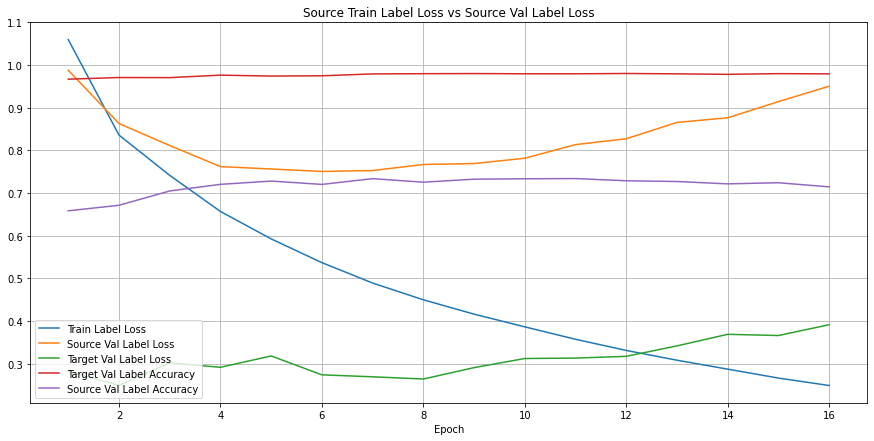

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

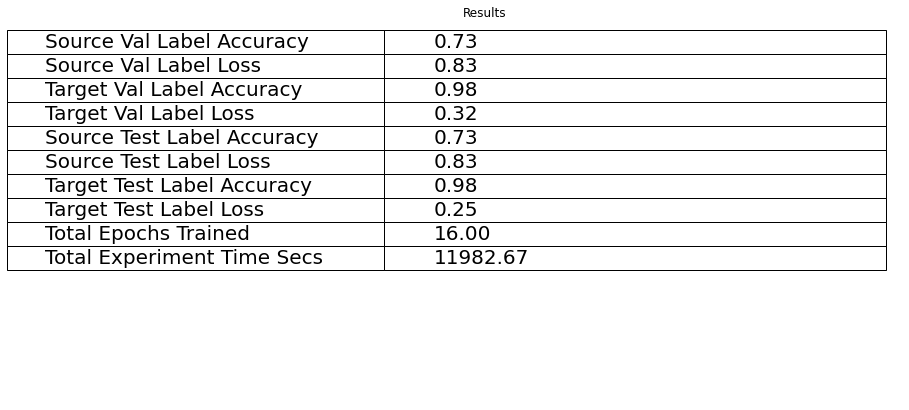

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

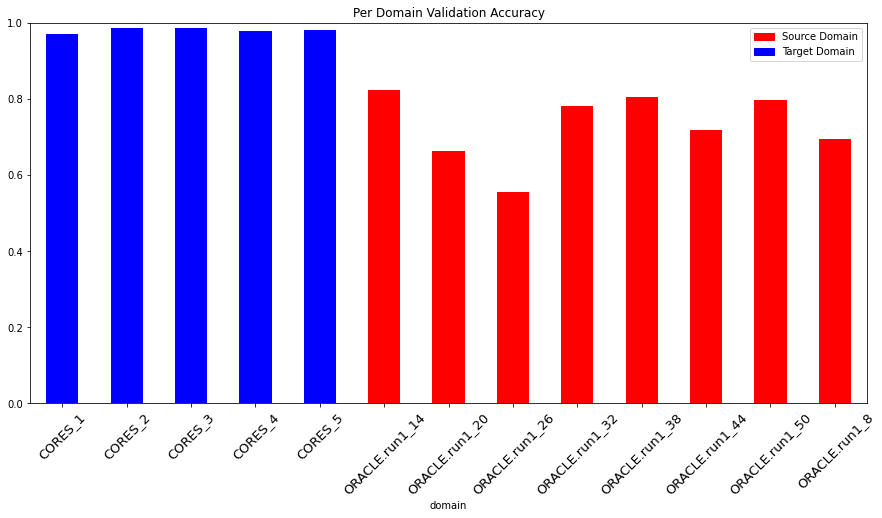

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7265169270833334 Target Test Label Accuracy: 0.9802981522956327
Source Val Label Accuracy: 0.7289713541666667 Target Val Label Accuracy: 0.9803346681922197


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:cores-oracle.run1", "parameters": {"experiment_name": "tl_1v2:cores-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL